# PPO (Proximal Policy Optimization)

Proximal Policy Optimization (PPO) is one of successful algorithms in today's reinforcement learning.

PPO is an algorithm that optimizes stochastic policy in on-policy way. However, in order to avoid the loss of performance, PPO algorithm prevents the update from stepping so far.<br>
To prevent large updates in PPO algorithm, there are two variants: PPO-Penalty and PPO-Clip. In this example, we'll focus on PPO-Penalty which is widely used in practical works.

> Note : The idea of PPO-Clip is more simple rather than PPO-Penalty. PPO-Clip limits the update by just clipping with $ \epsilon $.<br>
> For details about PPO-Clip, see [OpenAI document](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

As you saw in [Actor-Critic method](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb) (previous example), the algorithm will learn policy parameters $ \theta $ with advantages $ A $.<br>
When we assume that the agent takes large advantage $ A $ on action $ a $, $ P(a | \pi_\theta (s)) $ must be increased much more than $ P(a | \pi_{\theta_{old}} (s)) $, with new parameters $ \theta $.<br>
Hence you can expect new $ \theta $ as follows to optimize policy. :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A \right] $$

In order to prevent large policy updates, PPO penaltizes for this expectation as follows :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|penalty| \right] $$

where $ \beta $ is the coefficient for the weight of penalty.

In PPO-Penalty, KL-divergence is used for this penalty term. :

$$ \verb|penalty| := \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) $$

Now I briefly explain about KL-divergence (Kullback-Leibler divergence).<br>
We assume that both $ P(x) $ and $ Q(x) $ are stochastic distributions. KL-divergence $\verb|KL|( P \| Q )$ is then defined as follows and often used in information theory, such as, approximate inference.

$$ \verb|KL|( P \| Q ) := -\int{P(x) \ln{\frac{Q(x)}{P(X)}}}dx $$

By this definition, $ \verb|KL|( P \| Q ) $ will be always positive or zero, and zero if and only if both distributions are same.<br>
This means that $ \verb|KL|( P \| Q ) $ indicates how far between these distributions, $ P $ and $ Q $. If $ Q $ is so far from $ P $, $ \verb|KL|( P \| Q ) $ will become largely positive.

> Note : For details about entropy and KL-divergence, see chapter 1.6 in "[Pattern Recognition and Machine Learning](http://wordpress.redirectingat.com/?id=725X1342&isjs=1&jv=15.1.0-stackpath&sref=https%3A%2F%2Ftsmatz.wordpress.com%2F2020%2F06%2F01%2Fsvm-and-kernel-functions-mathematics%2F&url=https%3A%2F%2Fwww.microsoft.com%2Fen-us%2Fresearch%2Fuploads%2Fprod%2F2006%2F01%2FBishop-Pattern-Recognition-and-Machine-Learning-2006.pdf&xguid=&xs=1&xtz=-540&xuuid=c861da822b99f831a421716ca3a51d33&xcust=8982&xjsf=other_click__auxclick%20%5B2%5D)" (Christopher M. Bishop, Microsoft).<br>
> KL-divergence is not symmetric, $ \verb|KL|( P \| Q ) \neq \verb|KL|( Q \| P ) $, and also $ arg\,min_Q \verb|KL|( P \| Q ) \neq arg\,min_Q \verb|KL|( Q \| P ) $ when $P$ is given.

Now go back to our equation. In order to penaltize for large update between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $, we look for the optimal parameters $ \theta $, such as :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) \right]  \;\;\;\;\; (1) $$

Even if the first term $ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A $ largely increases, new $ \theta $ might be rejected when the difference between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $ is so large.

Finally we optimize policy function by maximizing (1), and optimize value function by minimizing value loss. 

See [this paper](https://arxiv.org/pdf/1707.06347.pdf) for more details about PPO.

> Note : In this example, we ignore (don't consider) an entropy regularizer. (See [SAC algorithm](./06-sac.ipynb) for entropy regularizer.)

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [ ]:
!pip install torch numpy gymnasium matplotlib

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

As you saw in [Actor-Critic](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb), now we build network (function) for actor and critic. (i.e, This is a network for both policy function and value function.)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

As I have mentioned above, we optimize policy function (actor) by maximizing (1), and optimize value function (critic) by minimizing value loss.

Instead of maximizing $ \frac{P(a | \theta_{new})}{P(a | \theta_{old})} A - \beta \cdot \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) $ and minimizing value loss $L$, here we simply minimize the following total loss value :

$$ (-1) \frac{P(a | \theta_{new})}{P(a | \theta_{old})} A + \beta \cdot \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) + L $$

In this example, both $P$ and $Q$ are discrete (categorical distribution), and KL-divergence is then :

$$ \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) = -\sum_a \left( P(a | \theta_{old}) \ln{\frac{P(a | \theta_{new})}{P(a | \theta_{old})}} \right) $$

Unlike previous [Actor-Critic example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb), we'll train both policy and value in a single optimization. Therefore, we'll assign loss ratio (the following ```vf_coeff```) in this example.

For temporal difference (TD) and GAE, see the description in [previous example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb). (For simplicity, I don't apply TD learning in this example.)

> Note : The log probability is equivalent to the negative value of cross-entropy error in categorical distribution. Same like previous examples, I have used ```-torch.nn.functional.cross_entropy()``` to get log probability in the following code.

> Note : For the purpose of your learning, here I implment computation for distributions from scratch, but you can also use ```torch.distributions``` package to simplify your code in PyTorch. (You can then use ```torch.distributions.kl.kl_divergence()``` to get KL-divergence.)

> Note : For stable training, advantage can also be normalized as $(A-\mu) / \sigma$, where $\mu$ is a mean and $\sigma$ is a standard deviation of advantages.<br>
> In this training, I haven't used normalized advantage.

In [3]:
gamma = 0.99    # discount

# These coefficients are experimentally determined in practice.
kl_coeff = 0.20  # weight coefficient for KL-divergence loss
vf_coeff = 0.50  # weight coefficient for value loss

# Pick up action and following properties for state (s)
# Return :
#     action (int)       action
#     logits (list[int]) logits defining categorical distribution
#     logprb (float)     log probability
def pick_sample_and_logp(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        #   --> size : (1)
        a = torch.multinomial(probs, num_samples=1)
        #   --> size : ()
        a = a.squeeze(dim=0)
        # Calculate log probability
        logprb = -F.cross_entropy(logits, a, reduction="none")

        # Return
        return a.tolist(), logits.tolist(), logprb.tolist()

env = gym.make("CartPole-v1")
reward_records = []
all_params = list(actor_func.parameters()) + list(value_func.parameters())
opt = torch.optim.AdamW(all_params, lr=0.0005)
for i in range(5000):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    logits = []
    logprbs = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a, l, p = pick_sample_and_logp(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        logits.append(l)
        logprbs.append(p)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #
    opt.zero_grad()
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    logits_old = torch.tensor(logits, dtype=torch.float).to(device)
    logprbs = torch.tensor(logprbs, dtype=torch.float).to(device)
    logprbs = logprbs.unsqueeze(dim=1)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    cum_rewards = cum_rewards.unsqueeze(dim=1)
    # Get values and logits with new parameters
    values_new = value_func(states)
    logits_new = actor_func(states)
    # Get advantages
    advantages = cum_rewards - values_new
    ### # Uncomment if you use normalized advantages (see above note)
    ### advantages = (advantages - advantages.mean()) / advantages.std()
    # Calculate P_new / P_old
    logprbs_new = -F.cross_entropy(logits_new, actions, reduction="none")
    logprbs_new = logprbs_new.unsqueeze(dim=1)
    prob_ratio = torch.exp(logprbs_new - logprbs)
    # Calculate KL-div for Categorical distribution (see above)
    l0 = logits_old - torch.amax(logits_old, dim=1, keepdim=True) # reduce quantity
    l1 = logits_new - torch.amax(logits_new, dim=1, keepdim=True) # reduce quantity
    e0 = torch.exp(l0)
    e1 = torch.exp(l1)
    e_sum0 = torch.sum(e0, dim=1, keepdim=True)
    e_sum1 = torch.sum(e1, dim=1, keepdim=True)
    p0 = e0 / e_sum0
    kl = torch.sum(
        p0 * (l0 - torch.log(e_sum0) - l1 + torch.log(e_sum1)),
        dim=1,
        keepdim=True)
    # Get value loss
    vf_loss = F.mse_loss(
        values_new,
        cum_rewards,
        reduction="none")
    # Get total loss
    loss = -advantages * prob_ratio + kl * kl_coeff + vf_loss * vf_coeff
    # Optimize
    loss.sum().backward()
    opt.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, np.sum(rewards)), end="\r")
    reward_records.append(np.sum(rewards))

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode2335 with rewards 500.0
Done


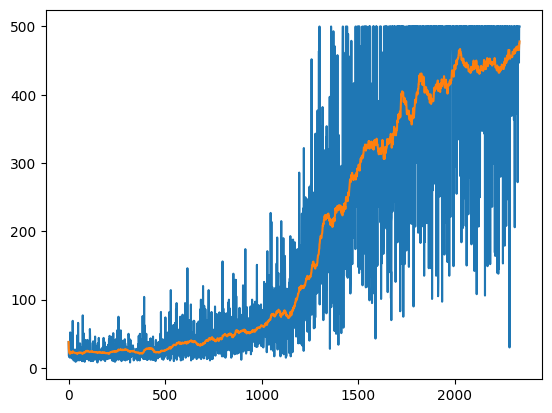

In [4]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)